In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
names = {
  'full_projectedgan': 'ProjectedGAN (Baseline)',
  'efficientnet-lite3': 'EfficientNet-Lite3', 
  'efficientnet-lite2': 'EfficientNet-Lite2',
  'augmentations_off': 'Augmentations off',
  'discriminator_1,2,3': 'Discriminator 1,2,3',
  'trainable_projections': 'Trainable Projections',
  'efficientnet-lite1': 'EfficientNet-Lite1',
  'discriminator_1,2': 'Discriminator 1,2',
  'no_cross_scale_mixing': 'No Cross Scale Mixing',
  'discriminator_1': 'Discriminator 1',
  'no_cross_scale_and_no_cross_channel_mixing': 'No Cross Scale/Channel Mixing',
  'diffusion_1000steps_train_250_steps_inference_58Ktraining': 'Diffusion',
  'randomly_initialized_feature_network': 'Random feature network',
  'unfreeze_feature_network': 'Unfreeze feature network',
  'randomly_initialized_feature_network_unfrozen': 'Randomly initialized feature network (unfrozen)',
  'unfreeze_feature_network+trainable_projections': 'Unfreeze feature network+Trainable Projections',
}
official = list(names.keys())

In [2]:
df = pd.read_csv("results.csv")
df['name'] = df['fake'].apply(lambda s:s.split("-CROPPED")[0] if "CROPPED" in s else s)
df = df[df.name != 'full_projectedgan_baseline']
df['res'] = df['fake'].apply(lambda s: "1024" if "CROPPED" not in s else s.split("CROPPED")[1])

In [15]:
d = df.copy()
print(d.net.unique())
metric = 'fid' # ['fid' 'kid' 'precision' 'recall']
net = 'inception_v3' # ['vicreg_rn50_inet' 'mae_vitb16' 'mae_solar_vitb16' 'vicreg_rn50_solar_v2' 'random_inception_v3' 'inception_v3' 'mae_solar_vitb16_v2' 'clip_rn50' 'dino_vitb16' 'vicreg_rn50_solar' 'inception_v3_other_block_0' 'mae_solarp128_vitb16']
res = 1024
d = d[d.metric==metric]
d = d[d.net==net]
d = d[d.res==str(res)]
d[['fake', 'value']].sort_values(by='value')

['vicreg_rn50_inet' 'mae_vitb16' 'mae_solar_vitb16' 'vicreg_rn50_solar_v2'
 nan 'random_inception_v3' 'inception_v3' 'mae_solar_vitb16_v2'
 'clip_rn50' 'dino_vitb16' 'vicreg_rn50_solar'
 'inception_v3_other_block_0' 'mae_solarp128_vitb16']


,fake,value
142,full_projectedgan,2.367752
562,efficientnet-lite3,3.795707
339,efficientnet-lite2,4.072818
480,augmentations_off,4.193335
287,"discriminator_1,2,3",6.452496
146,trainable_projections,7.217482
14,efficientnet-lite1,7.424706
70,"discriminator_1,2",7.431100
296,no_cross_scale_mixing,9.599026
29,discriminator_1,10.690697


# Diffusion Results

In [40]:
import seaborn as sns

def parse_diffusion(row):
    name = row['fake']
    tokens = name.split("_")
    train_timesteps = int(tokens[1].replace("steps", ""))
    test_timesteps = int(tokens[3])
    random_flip = False if "no_random_flip" in name else True
    small_unet = True if "small_unet" in name else False
    dropout = True if "dropout" in name else False
    return {"train_timesteps": train_timesteps, "test_timesteps": test_timesteps, "random_flip": random_flip, "small_unet": small_unet, "dropout": dropout, 'FID': row['value']}
rows = []
diffusion = d[(d.name.str.startswith("diffusion"))] # only diffusion models

for index, row in diffusion.iterrows():
    row = parse_diffusion(row)
    rows.append(row)
diffusion = pd.DataFrame(rows)
diffusion = diffusion.sort_values(by='FID')

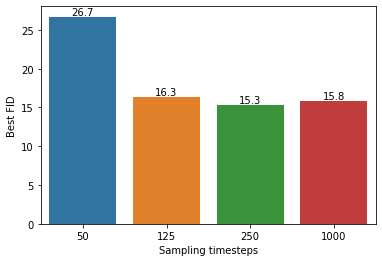

In [41]:
D = diffusion[(diffusion.train_timesteps==1000) & (diffusion.small_unet==False) & (diffusion.dropout==False) & (diffusion.random_flip==True)].sort_values(by="test_timesteps")
D["Sampling timesteps"] = D["test_timesteps"]
D["Best FID"] = D["FID"]
D = D.round(1)
ax = sns.barplot(x='Sampling timesteps', y='Best FID',data=D)
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

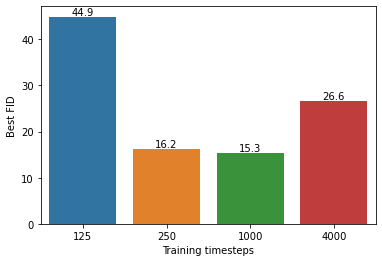

In [43]:
D = diffusion[(diffusion.small_unet==False) & (diffusion.dropout==False) & (diffusion.random_flip==True)]
D = D.sort_values(by="FID")
D["Best FID"] = D["FID"]
D = D[D.train_timesteps.isin([125,250,1000,4000])]
D = D.drop_duplicates(subset=["train_timesteps"], keep="first")
D = D.sort_values(by="train_timesteps")
D["Training timesteps"] = D["train_timesteps"]
D = D.round(1)
ax = sns.barplot(x='Training timesteps', y='Best FID',data=D)
for i in ax.containers:
    ax.bar_label(i,)
plt.show()

In [45]:
D = diffusion[(diffusion.train_timesteps==1000) & (diffusion.test_timesteps==250)]
#& ((diffusion.small_unet==True) | (diffusion.dropout==True) | (diffusion.random_flip==False))]
#D.labels = ["
D = D.sort_values(by="FID", ascending=False)
#D.labels = ["
D = D.round(1)
D["Model"] = ["Random horizontal flip + Reduced model capacity", "No regularization", "Dropout=0.3", "Random Horizontal flip"]
#print(D[["Model", "FID"]].to_latex(index=False))
D[["Model", "FID"]]

,Model,FID
3,Random horizontal flip + Reduced model capacity,43.3
1,No regularization,28.1
6,Dropout=0.3,25.4
2,Random Horizontal flip,15.3


# Spearman correlation $\rho$ between different metrics

In [46]:
from scipy import stats
from itertools import product, combinations
import numpy as np
df_official = df[df.name.isin(official)]
metrics = df_official.metric.unique()
nets = df_official.net.dropna().unique()
nets = [m for m in nets if m not in ('dino_vitb16', 'inception_v3_other_block_0', 'mae_solar_vitb16_v2', 'vicreg_rn50_solar')]
res = ['1024']
sp = {}
P = list(product(metrics, nets, res))
#print(P)
keys = set()
rows = []
N = {
    ('fid', 'random_inception_v3', '1024'): "rFID",
    ('fid', 'inception_v3', '1024'): "FID",
    ('IS', 'inception_v3', '1024'): "IS",
    ('fid', 'clip_rn50', '1024'): "CLIP-RN50",
    ('kid', 'inception_v3', '1024'): "KID",
    ('precision', 'inception_v3', '1024'): "Precision",
    ('recall', 'inception_v3', '1024'): "Recall",
    ('fid', 'mae_vitb16', '1024'): "MAE-INET-FID",
    ('fid', 'mae_solar_vitb16', '1024'): "MAE-SOLAR-FID",
    ('fid', 'vicreg_rn50_inet', '1024'): "VICREG-INET-FID",
    ('fid', 'vicreg_rn50_solar_v2', '1024'): "VICREG-SOLAR-FID",

}
for o1, o2 in combinations(P, 2):
    d1 = df_official[(df_official.metric==o1[0])&(df_official.net==o1[1])&(df_official.res==o1[2])]
    d2 = df_official[(df_official.metric==o2[0])&(df_official.net==o2[1])&(df_official.res==o2[2])]
    if set(d1.name.unique()) == set(d2.name.unique()) and len(d1):
        d1 = d1.sort_values(by="name")
        d2 = d2.sort_values(by="name")
        assert np.all(d1.name.values == d2.name.values)
        
        #r1 = pd.concat((d1,d1.rank(axis=0)), axis=1).value
        r1 = d1.rank(axis=0).value.values.astype(int)
        r2 = d2.rank(axis=0).value.values.astype(int)
        res = stats.spearmanr(r1, r2)
        #print(o1, o2, res.correlation)
        sp[(o1, o2)] = res.correlation
        sp[(o2, o1)] = res.correlation
        #print(res.statistic, res.pvalue)
        #print(r)
        #keys.add(o1)
        #keys.add(o2)
        o1 = N[o1]
        o2 = N[o2]
        keys.add(o1)
        keys.add(o2)
        #print(o1, o2, res.correlation)
        rows.append({"m1": o1, "m2": o2, "val": res.correlation})
        rows.append({"m1": o2, "m2": o1, "val": res.correlation})

for k in keys:
    rows.append({"m1": k, "m2":k, "val": 1.0})
        
D = pd.DataFrame(rows)
D = pd.pivot(D, "m1", "m2", "val")

D = D.reindex(['FID', 'rFID', 'KID', 'CLIP-RN50', 'Precision', 'Recall', 'MAE-INET-FID', 'MAE-SOLAR-FID', 'VICREG-INET-FID', 'VICREG-SOLAR-FID'])
D = D[(['FID', 'rFID', 'KID', 'CLIP-RN50', 'Precision', 'Recall', 'MAE-INET-FID', 'MAE-SOLAR-FID', 'VICREG-INET-FID', 'VICREG-SOLAR-FID'])]

D = D.round(2)
#print(D.to_latex(index=True))
D

m2,FID,rFID,KID,CLIP-RN50,Precision,Recall,MAE-INET-FID,MAE-SOLAR-FID,VICREG-INET-FID,VICREG-SOLAR-FID
m1,,,,,,,,,,
FID,1.00,0.75,0.97,0.94,-0.74,-0.71,0.98,0.53,0.98,0.78
rFID,0.75,1.00,0.68,0.64,-0.44,-0.83,0.75,0.73,0.71,0.98
KID,0.97,0.68,1.00,0.97,-0.76,-0.64,0.96,0.48,0.96,0.72
CLIP-RN50,0.94,0.64,0.97,1.00,-0.86,-0.58,0.96,0.51,0.95,0.69
Precision,-0.74,-0.44,-0.76,-0.86,1.00,0.31,-0.81,-0.41,-0.79,-0.48
Recall,-0.71,-0.83,-0.64,-0.58,0.31,1.00,-0.66,-0.81,-0.69,-0.83
MAE-INET-FID,0.98,0.75,0.96,0.96,-0.81,-0.66,1.00,0.54,0.96,0.79
MAE-SOLAR-FID,0.53,0.73,0.48,0.51,-0.41,-0.81,0.54,1.00,0.53,0.72
VICREG-INET-FID,0.98,0.71,0.96,0.95,-0.79,-0.69,0.96,0.53,1.00,0.76


# Patch FID

In [22]:
pd.set_option('display.max_colwidth', None)
dfp = df.copy()
dfp = dfp[dfp.net=='inception_v3']
dfp= dfp[dfp.metric == 'fid']
dfp = pd.pivot(dfp, "name",  "res", "value")
dfp = dfp.reset_index()
dfp = dfp.sort_values(by="1024")
dfp.index = np.arange(len(dfp))
dfp["Model"] = dfp.name.apply(lambda n:names.get(n,n))
dfp["FID"] = dfp["1024"]
dfp["FID-p64"] = dfp["64"]
dfp["FID-p128"] = dfp["128"]
dfp["FID-p256"] = dfp["256"]
#dfp = dfp[["Model", "FID", "FID-p64"]]
dfp = dfp[["Model", "FID", "FID-p64", "FID-p128", "FID-p256"]]
#dfp = dfp[["Model", "FID", "FID-p64", "FID-p128"]]
dfp = dfp.round(decimals=6)
dfp
#print(dfp.to_latex(index=False))

res,Model,FID,FID-p64,FID-p128,FID-p256
0,ProjectedGAN (Baseline),2.367752,1.009764,0.843592,0.971617
1,EfficientNet-Lite3,3.795707,0.955178,0.985581,1.244725
2,EfficientNet-Lite2,4.072818,1.051904,0.900489,0.958093
3,Augmentations off,4.193335,3.675632,3.547073,1.623088
4,"Discriminator 1,2,3",6.452496,1.068834,1.183031,1.789787
5,Trainable Projections,7.217482,2.373210,2.145253,2.598798
6,EfficientNet-Lite1,7.424706,1.276902,1.586017,2.076311
7,"Discriminator 1,2",7.431100,1.368804,1.729971,2.256217
8,No Cross Scale Mixing,9.599026,1.182289,1.508497,2.550815
9,Discriminator 1,10.690697,2.544695,2.859082,4.000306


# Metric details

In [57]:
from IPython.display import HTML, display
pd.set_option('display.max_colwidth', None)
dfp = df.copy()
dfp = dfp[dfp.name.isin(official)]
#dfp = dfp[dfp.net=='random_inception_v3']
dfp['net_metric'] = dfp.apply(lambda di:str(di['net'])+'_'+str(di['metric']),axis=1)
#dfp = dfp[(dfp.net=='inception_v3') | (dfp.net == 'random_inception_v3')]
dfp = dfp[dfp.res == '1024']
#dfp = dfp[dfp.net=='inception_v3_other_block_0']
#dfp= dfp[dfp.metric == 'kid']
#dfp= dfp[dfp.metric == 'fid']
#print(dfp.net.unique())
#print(dfp.metric.unique())
dfp = pd.pivot(dfp, "name",  "net_metric", "value")
dfp = dfp.reset_index()
dfp = dfp.sort_values(by="inception_v3_fid")
dfp.index = np.arange(len(dfp))
#print(dfp.columns)
dfp['FID'] = dfp['inception_v3_fid']
dfp['rFID'] = dfp['random_inception_v3_fid'] * 10**3
dfp['KID'] = dfp['inception_v3_kid'] * 10**3
dfp['CLIP-RN50-FID'] = dfp['clip_rn50_fid']  * 10**3
dfp['Precision'] = dfp['inception_v3_precision']
dfp['Recall'] = dfp['inception_v3_recall']
dfp['MAE-INET-FID'] = dfp['mae_vitb16_fid'] * 10**2
dfp['MAE-SOLAR-FID'] = dfp['mae_solar_vitb16_fid']  * 10**2
dfp['VICREG-INET-FID'] = dfp['vicreg_rn50_inet_fid'] 
dfp['VICREG-SOLAR-FID'] = dfp['vicreg_rn50_solar_fid']  
#dfp['IS']  = dfp['inception_v3_IS']
#dfp['kid'] = dfp['KID']
#dfp['precision'] = dfp['Precision']
#dfp['recall'] = dfp['Recall']
dfp["Model"] = dfp.name.apply(lambda n:names.get(n, n))
#print(dfp.columns)
dfp = dfp[["Model", "FID", "rFID", "KID", "CLIP-RN50-FID", "MAE-INET-FID", "MAE-SOLAR-FID", "VICREG-INET-FID", "VICREG-SOLAR-FID", "Precision", "Recall"]]
#dfp = dfp[["Model", "FID", "MAE-INET-FID", "MAE-SOLAR-FID", "VICREG-INET-FID", "VICREG-SOLAR-FID"]]
dfp = dfp.copy()
#dfp = dfp[["Model", "FID", "IS"]]
#dfp = dfp.sort_values(by="IS", ascending=False)
#dfp = dfp.round(decimals=2)
#print(dfp.to_latex(index=False))
#print(dfp.to_markdown(index=False))
#dfp.style.format("{:.2ff}", subset=["IS"]).format("{:.2f}", subset=["FID"]).hide(axis=0)
dfp = dfp.round(2)
#print(dfp.to_latex(index=False))
dfp

net_metric,Model,FID,rFID,KID,CLIP-RN50-FID,MAE-INET-FID,MAE-SOLAR-FID,VICREG-INET-FID,VICREG-SOLAR-FID,Precision,Recall
0,ProjectedGAN (Baseline),2.37,10.79,0.74,12.10,8.44,29.49,3.29,4.99,0.60,0.84
1,EfficientNet-Lite3,3.80,13.08,1.61,20.42,12.44,29.87,4.88,5.80,0.54,0.71
2,EfficientNet-Lite2,4.07,13.17,0.99,13.43,11.14,29.88,4.45,5.52,0.58,0.75
3,Augmentations off,4.19,17.34,1.62,10.81,9.55,29.07,5.03,5.59,0.66,0.51
4,"Discriminator 1,2,3",6.45,19.25,2.50,20.48,14.10,29.77,7.84,6.68,0.65,0.29
5,Trainable Projections,7.22,15.12,3.88,31.89,16.09,30.72,8.42,6.20,0.48,0.57
6,EfficientNet-Lite1,7.42,18.14,4.31,24.91,18.53,30.11,8.33,6.53,0.63,0.47
7,"Discriminator 1,2",7.43,24.99,3.15,26.35,20.29,31.50,8.40,7.08,0.54,0.33
8,No Cross Scale Mixing,9.60,28.75,2.89,22.91,18.79,33.27,10.21,8.46,0.60,0.15
9,Discriminator 1,10.69,22.40,6.15,37.54,27.06,31.71,10.40,7.76,0.47,0.39


In [58]:
dfp_extended = dfp[["Model", "FID", "MAE-INET-FID", "MAE-SOLAR-FID", "VICREG-INET-FID", "VICREG-SOLAR-FID"]].copy()
row = [{
 'Model': '', 
 'FID': "$\\rho$=1", 
 "MAE-INET-FID": f"$\\rho={(sp[(('fid', 'inception_v3', '1024'), ('fid', 'mae_vitb16', '1024'))]):.2f}$", 
 "MAE-SOLAR-FID": f"$\\rho={(sp[(('fid', 'inception_v3', '1024'), ('fid', 'mae_solar_vitb16', '1024'))]):.2f}$",
 "VICREG-INET-FID": f"$\\rho={(sp[(('fid', 'inception_v3', '1024'), ('fid', 'vicreg_rn50_inet', '1024'))]):.2f}$", 
 "VICREG-SOLAR-FID":f"$\\rho={(sp[(('fid', 'inception_v3', '1024'), ('fid', 'vicreg_rn50_solar_v2', '1024'))]):.2f}$",
}]
rhos = pd.DataFrame(row)
def f(v):
    if type(v) == float:
        return f"{v:.2f}"
    else:
        return v
def highlight_min(s, props=''):
    return np.where(s == np.nanmin(s.values), props, '')
def highlight_second_min(s, props=''):
    second_min = sorted(s.values)[1]
    return np.where(s == second_min, props, '')

dfp_extended.index = np.arange(len(dfp_extended))
dfp_extended = dfp_extended.style
dfp_extended = dfp_extended.apply(highlight_min, props='color:red;background-color:white;font-weight:bold', subset=["FID", "MAE-INET-FID", "MAE-SOLAR-FID", "VICREG-INET-FID", "VICREG-SOLAR-FID"], axis=0)
dfp_extended = dfp_extended.apply(highlight_second_min, props='color:blue;background-color:white', subset=["FID", "MAE-INET-FID", "MAE-SOLAR-FID", "VICREG-INET-FID", "VICREG-SOLAR-FID"], axis=0)
dfp_extended = dfp_extended.format(f, subset=["FID", "MAE-INET-FID", "MAE-SOLAR-FID", "VICREG-INET-FID", "VICREG-SOLAR-FID"])
#dfp_extended = dfp_extended.hide(axis=0)
display(HTML(dfp_extended.to_html()))
display(HTML(rhos.drop("Model",axis=1).to_html(index=False)))

net_metric,Model,FID,MAE-INET-FID,MAE-SOLAR-FID,VICREG-INET-FID,VICREG-SOLAR-FID
0,ProjectedGAN (Baseline),2.37,8.44,29.49,3.29,4.99
1,EfficientNet-Lite3,3.80,12.44,29.87,4.88,5.80
2,EfficientNet-Lite2,4.07,11.14,29.88,4.45,5.52
3,Augmentations off,4.19,9.55,29.07,5.03,5.59
4,"Discriminator 1,2,3",6.45,14.10,29.77,7.84,6.68
5,Trainable Projections,7.22,16.09,30.72,8.42,6.20
6,EfficientNet-Lite1,7.42,18.53,30.11,8.33,6.53
7,"Discriminator 1,2",7.43,20.29,31.50,8.40,7.08
8,No Cross Scale Mixing,9.60,18.79,33.27,10.21,8.46
9,Discriminator 1,10.69,27.06,31.71,10.40,7.76


FID,MAE-INET-FID,MAE-SOLAR-FID,VICREG-INET-FID,VICREG-SOLAR-FID
$\rho$=1,$\rho=0.98$,$\rho=0.53$,$\rho=0.98$,$\rho=0.78$
